In [1]:
import sys
import os

sys.path.append('/Users/pimpijnenburg/Desktop/Thesis/USTC_SmokeRS_dataset/code/transfer_learning/training')

In [2]:
from tl_tools import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np
import torch 
from torch import from_numpy
import torch.nn as nn
from torchvision.models import convnext_small, ConvNeXt_Small_Weights
from torch.utils.data import TensorDataset, DataLoader
setup_mixed_precision()

Mixed precision policy set to: mixed_float16



In [3]:
resnet50v1_path = '/Users/pimpijnenburg/Desktop/Thesis/USTC_SmokeRS_dataset/code/transfer_learning/trained_models/resnet_50v1.keras'
resnet101v2_path = '/Users/pimpijnenburg/Desktop/Thesis/USTC_SmokeRS_dataset/code/transfer_learning/trained_models/resnet101v2.keras'
nasnet_path = '/Users/pimpijnenburg/Desktop/Thesis/USTC_SmokeRS_dataset/code/transfer_learning/trained_models/nasnet_mobile.keras'
convnext_path = torch.load('/Users/pimpijnenburg/Desktop/Thesis/USTC_SmokeRS_dataset/code/transfer_learning/trained_models/convnext_model.pth', weights_only=False)

In [4]:
convnext = convnext_small(weights=ConvNeXt_Small_Weights.IMAGENET1K_V1)
convnext.classifier = nn.Sequential(
    nn.Flatten(),     
    
    #FC 1                       
    nn.Linear(in_features=768, out_features=64),   
    nn.ReLU(),
    nn.BatchNorm1d(64), 
    nn.Dropout1d(p=0.3), 
           
    #FC 2                                           
    nn.Linear(in_features=64, out_features=32),
    nn.ReLU(), 
    nn.BatchNorm1d(32),  
    nn.Dropout1d(p=0.3), 
    
    #Softmax
    nn.Linear(in_features=32, out_features=6),  
    nn.Softmax(dim=1)                                           
)
for param in convnext.features.parameters(): 
    param.requires_grad = False
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
convnext = convnext.to(device)

resnet50v1 = load_model(resnet50v1_path)
resnet101v2 = load_model(resnet101v2_path)
nasnet_mobile = load_model(nasnet_path)
convnext.load_state_dict(convnext_path['model_state_dict'])

2024-11-15 17:31:37.144263: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-11-15 17:31:37.144282: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-11-15 17:31:37.144285: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-11-15 17:31:37.144445: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-15 17:31:37.144459: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<All keys matched successfully>

In [5]:
test_dir = '/Users/pimpijnenburg/Desktop/Thesis/USTC_SmokeRS_dataset/data/USTC_SmokeRS/processed/test'
test_datagen = ImageDataGenerator(rescale=1./255)
test = test_datagen.flow_from_directory(test_dir, color_mode= 'rgb', batch_size = 16, shuffle= False, seed = 1, target_size=(256, 256))

#Tensorflow setup
X_test, y_test = test_splits(test)

#Torch setup 
X_test_torch = from_numpy(X_test.numpy()).permute(0, 3, 1, 2)
y_test_torch = from_numpy(y_test.numpy())

test_dataset = TensorDataset(X_test_torch, y_test_torch)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle = False)

Found 1245 images belonging to 6 classes.
Number of batches in the test data: 78
Batch size of a single batch 16
Number of samples in the test dataset 1245

Shape of image test set: (1245, 256, 256, 3)

Shape of label test set: (1245, 6)


In [6]:
#Tensorflow proba and pred 
proba_resnet50v1 = resnet50v1.predict(X_test)
pred_resnet50v1 = tf.argmax(proba_resnet50v1, axis = 1).numpy()

proba_resnet101v2 = resnet101v2.predict(X_test)
pred_resnet101v2 = tf.argmax(proba_resnet101v2, axis = 1).numpy()

proba_nasnetmobile = nasnet_mobile.predict(X_test)
pred_nasnetmobile = tf.argmax(proba_nasnetmobile, axis = 1).numpy()

#Tensorflow true labels
tf_y_true = tf.argmax(y_test, axis=1).numpy()

2024-11-15 17:31:45.457830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 253ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 18s 376ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 27s 467ms/step


In [7]:
#Torch proba and pred
convnext.eval()  
with torch.no_grad():
    probas = list()
    predictions = list()
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = convnext(inputs)
        
        #Probas
        proba = torch.nn.functional.softmax(outputs, dim=1)
        
        #Pred
        _, predicted = torch.max(outputs, 1)
        
        probas.extend(proba.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())

    proba_convnextsmall = np.array(probas)
    pred_convnextsmall = np.array(predictions)

#Torch true labels
true_labels = list()
with torch.no_grad():
    for _, targets in test_loader:
        true_labels.extend(torch.argmax(targets, dim=1).numpy())

torch_y_true = np.array(true_labels)

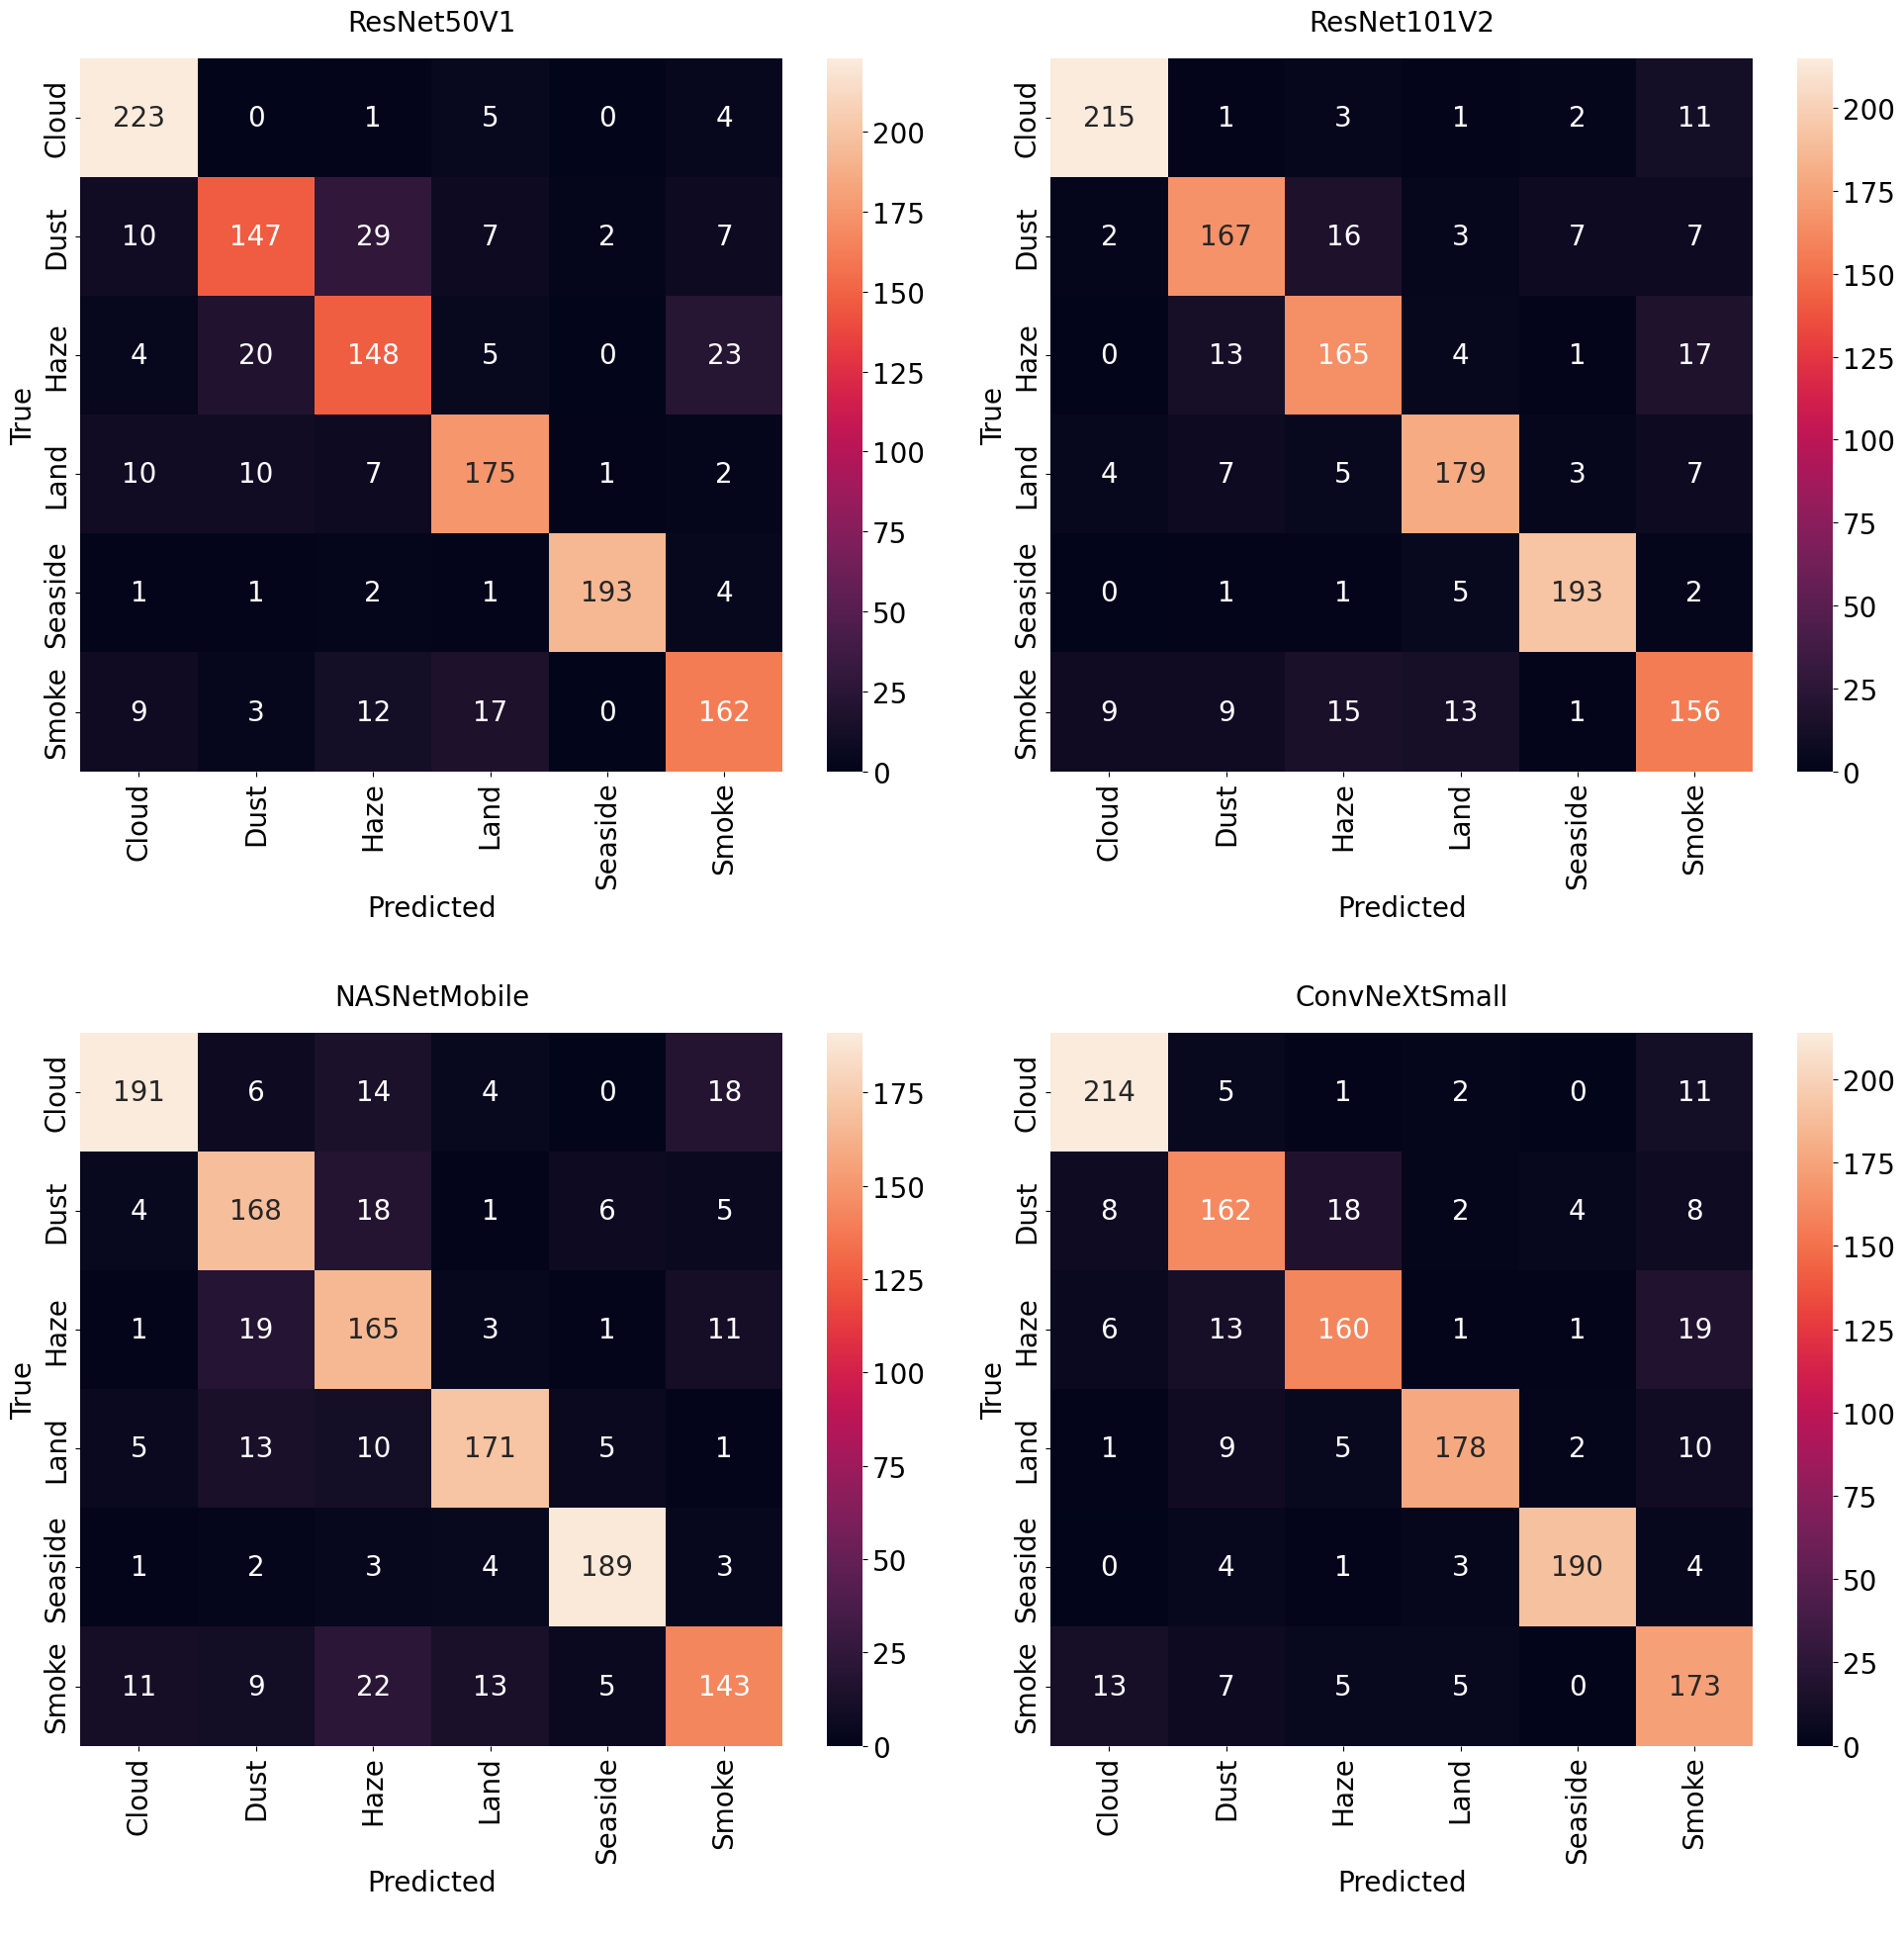

In [8]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class_labels = list(test.class_indices.keys())

plt.rcParams.update({'font.size': 20})
fig, axes = plt.subplots(2,2, figsize = (20,20))
axes = axes.flatten()

predictions = [
    (pred_resnet50v1, "ResNet50V1"),
    (pred_resnet101v2, "ResNet101V2"),
    (pred_nasnetmobile, "NASNetMobile"),
    (pred_convnextsmall, "ConvNeXtSmall")
]

for i, (pred, name) in enumerate(predictions): 
    true_labels = tf_y_true if name != 'ConvNeXtSmall' else torch_y_true
    
    cm = confusion_matrix(true_labels, pred)
    sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'rocket', xticklabels= class_labels, yticklabels= class_labels, ax = axes[i])
    axes[i].set_title(f'{name}', fontsize = 20, pad = 20)
    axes[i].set_xlabel('Predicted\n', fontsize = 20)
    axes[i].set_ylabel('True' , fontsize = 20)

plt.tight_layout()

image_output_dir = '/Users/pimpijnenburg/Desktop/Thesis/USTC_SmokeRS_dataset/data/generated_images'
plot_output = os.path.join(image_output_dir, 'confusion_matrices.png')
#plt.savefig(plot_output)

plt.show()


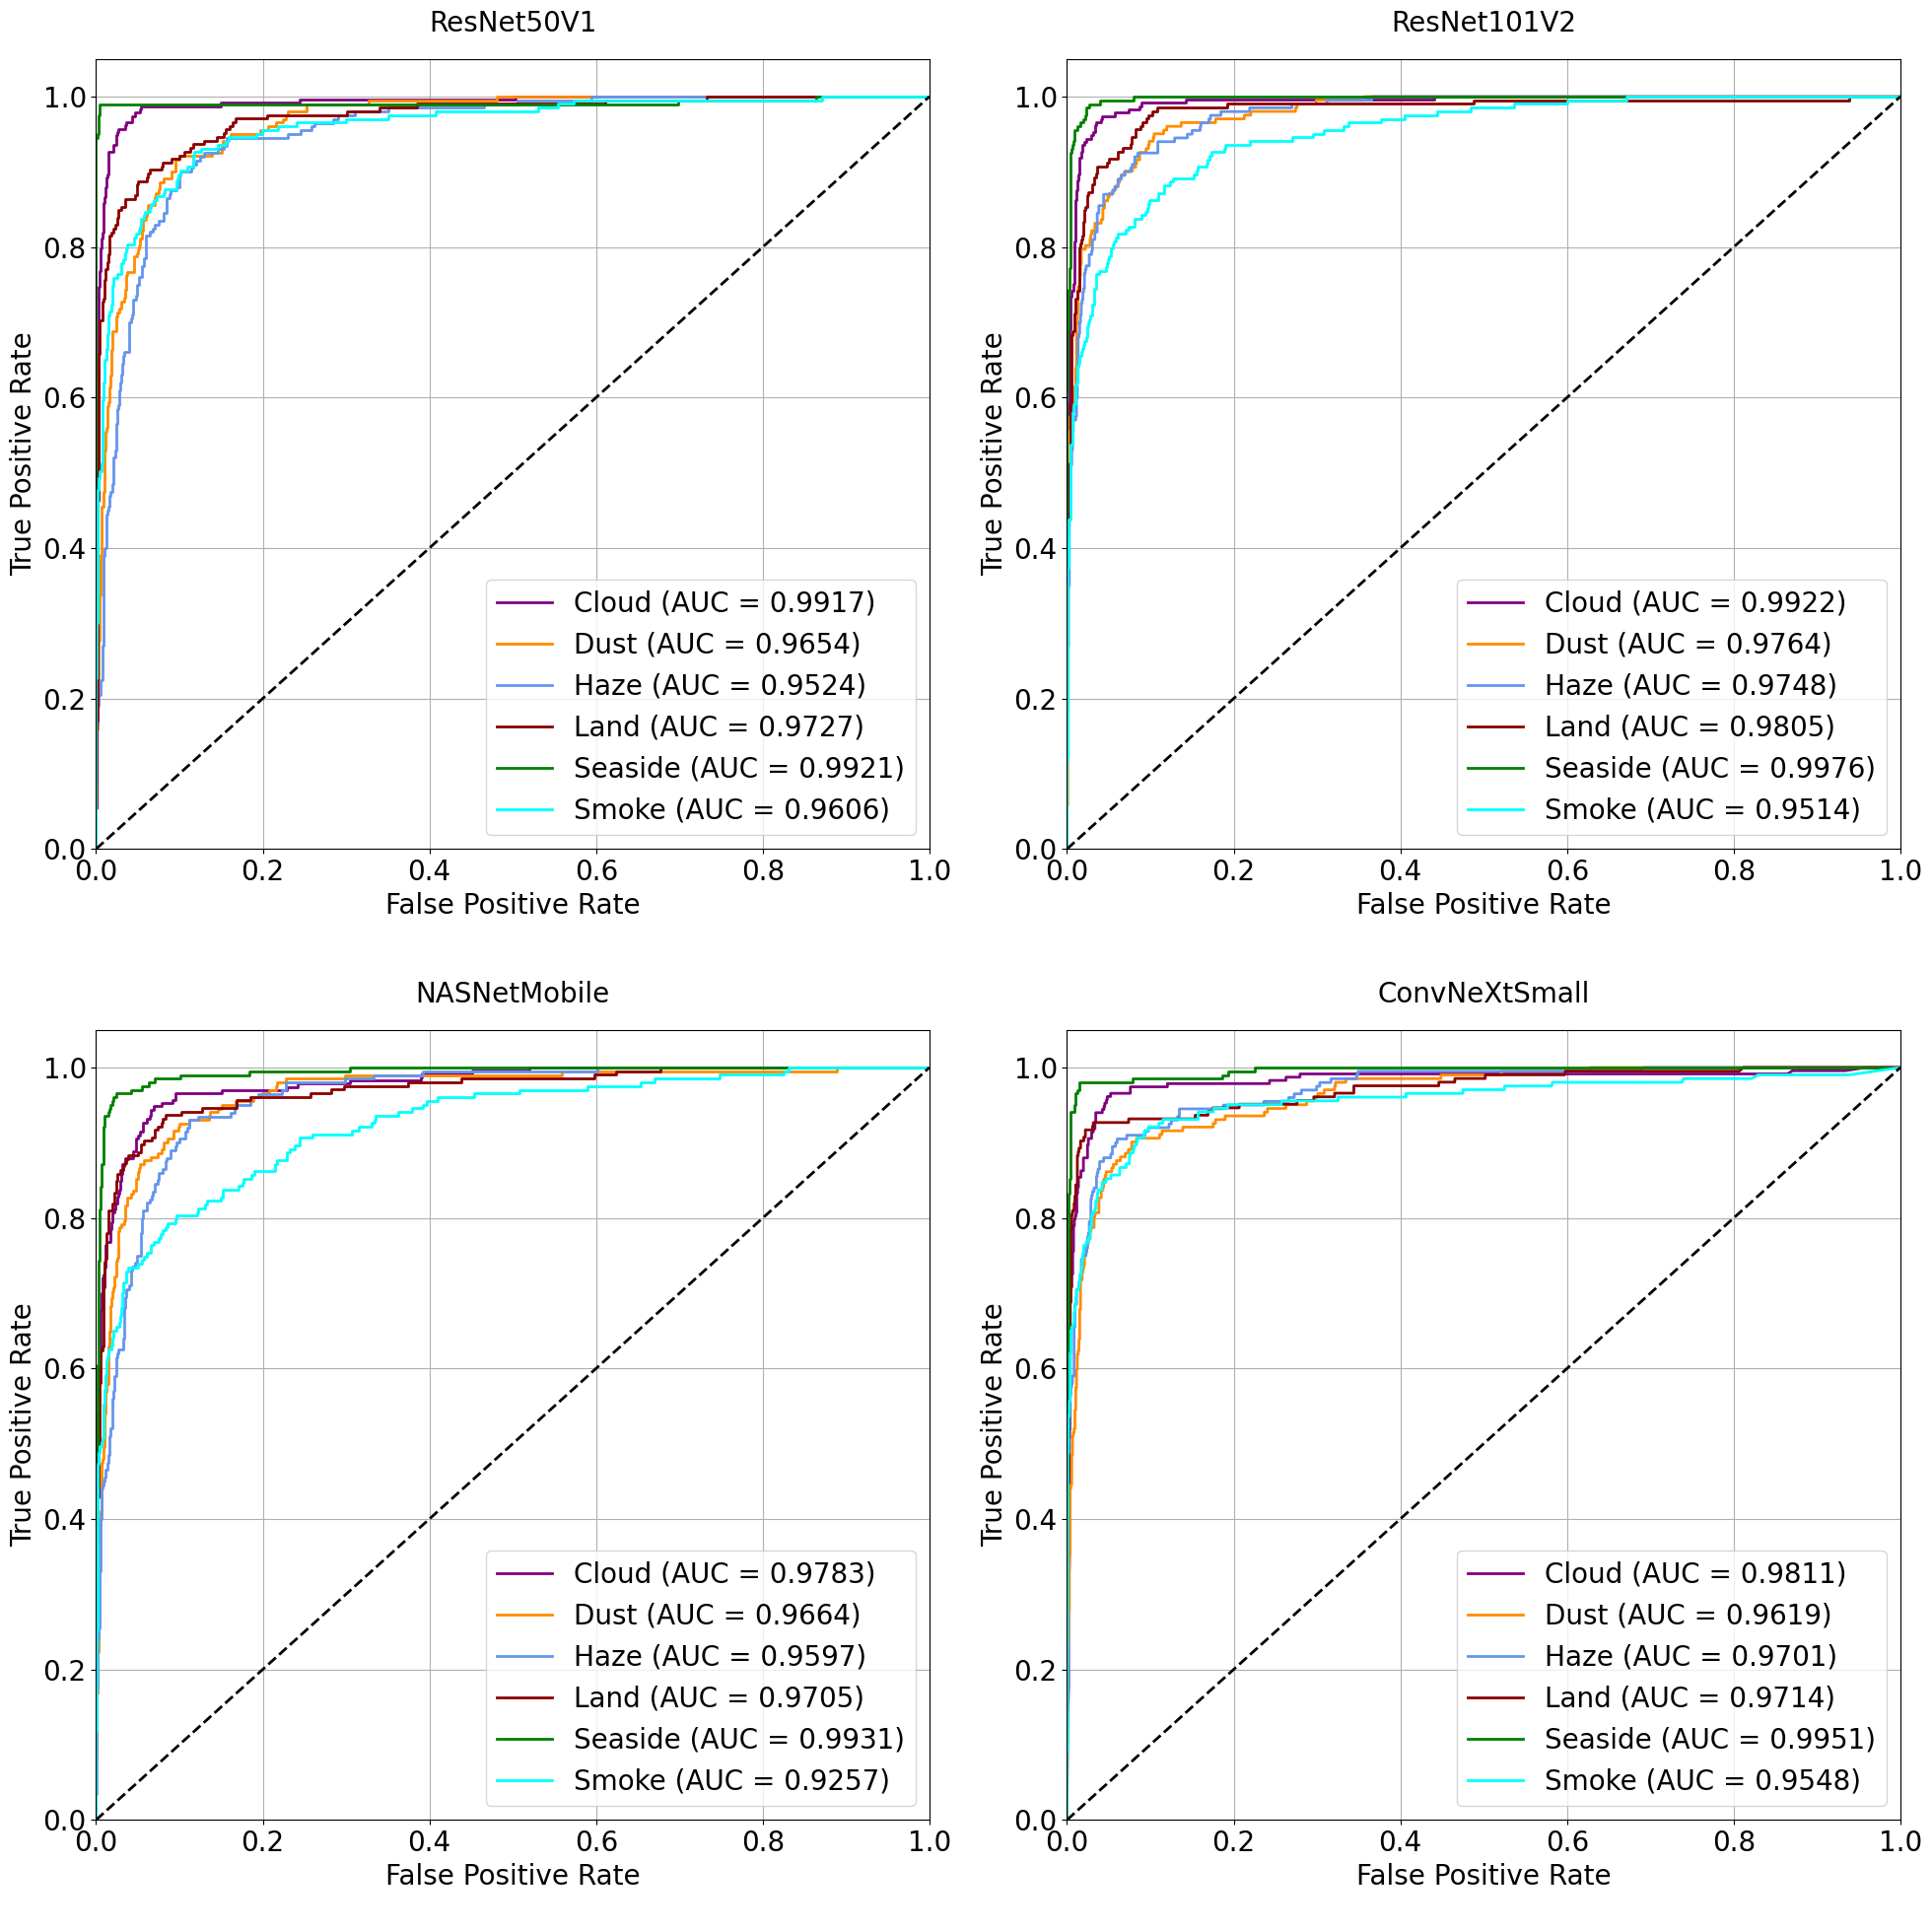

In [9]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

fig, axes = plt.subplots(2,2, figsize = (20,20))
axes = axes.flatten()

predictions = [
    (proba_resnet50v1, "ResNet50V1"),
    (proba_resnet101v2, "ResNet101V2"),
    (proba_nasnetmobile, "NASNetMobile"),
    (proba_convnextsmall, "ConvNeXtSmall")
]

# Create fixed color mapping for classes
color_dict = {
    'Cloud': 'purple',
    'Dust': 'darkorange',
    'Haze': 'cornflowerblue',
    'Land': 'darkred',
    'Seaside': 'green',
    'Smoke': 'aqua'
}

n_classes = len(class_labels)

for i, (proba, name) in enumerate(predictions):
    true_labels = tf_y_true if name != 'ConvNeXtSmall' else torch_y_true
    true_labels_binary = label_binarize(true_labels, classes=np.arange(n_classes))
    
    # Calculate ROC AUC scores first
    roc_auc_scores = []
    for class_idx in range(n_classes):
        score = roc_auc_score(true_labels_binary[:, class_idx], proba[:, class_idx])
        roc_auc_scores.append(score)
    
    # Plot ROC curves
    for class_idx, auc_score in enumerate(roc_auc_scores):
        class_name = class_labels[class_idx]
        fpr, tpr, _ = roc_curve(true_labels_binary[:, class_idx], proba[:, class_idx])
        axes[i].plot(fpr, tpr, color=color_dict[class_name], lw=2,
                    label=f'{class_name} (AUC = {auc_score:.4f})')
    
    axes[i].plot([0, 1], [0, 1], 'k--', lw=2)
    axes[i].set_xlim([0.0, 1.0])
    axes[i].set_ylim([0.0, 1.05])
    axes[i].set_xlabel('False Positive Rate\n', fontsize=20)
    axes[i].set_ylabel('True Positive Rate', fontsize=20)
    axes[i].set_title(f'{name}', fontsize=20, pad=20)
    axes[i].legend(loc="lower right", fontsize=20)
    axes[i].grid(True)

plt.tight_layout()
plot_output = os.path.join(image_output_dir, 'roc_curves.png')
#plt.savefig(plot_output)
plt.show()

Number of images that each architecture predicted the same wrong class on: 14


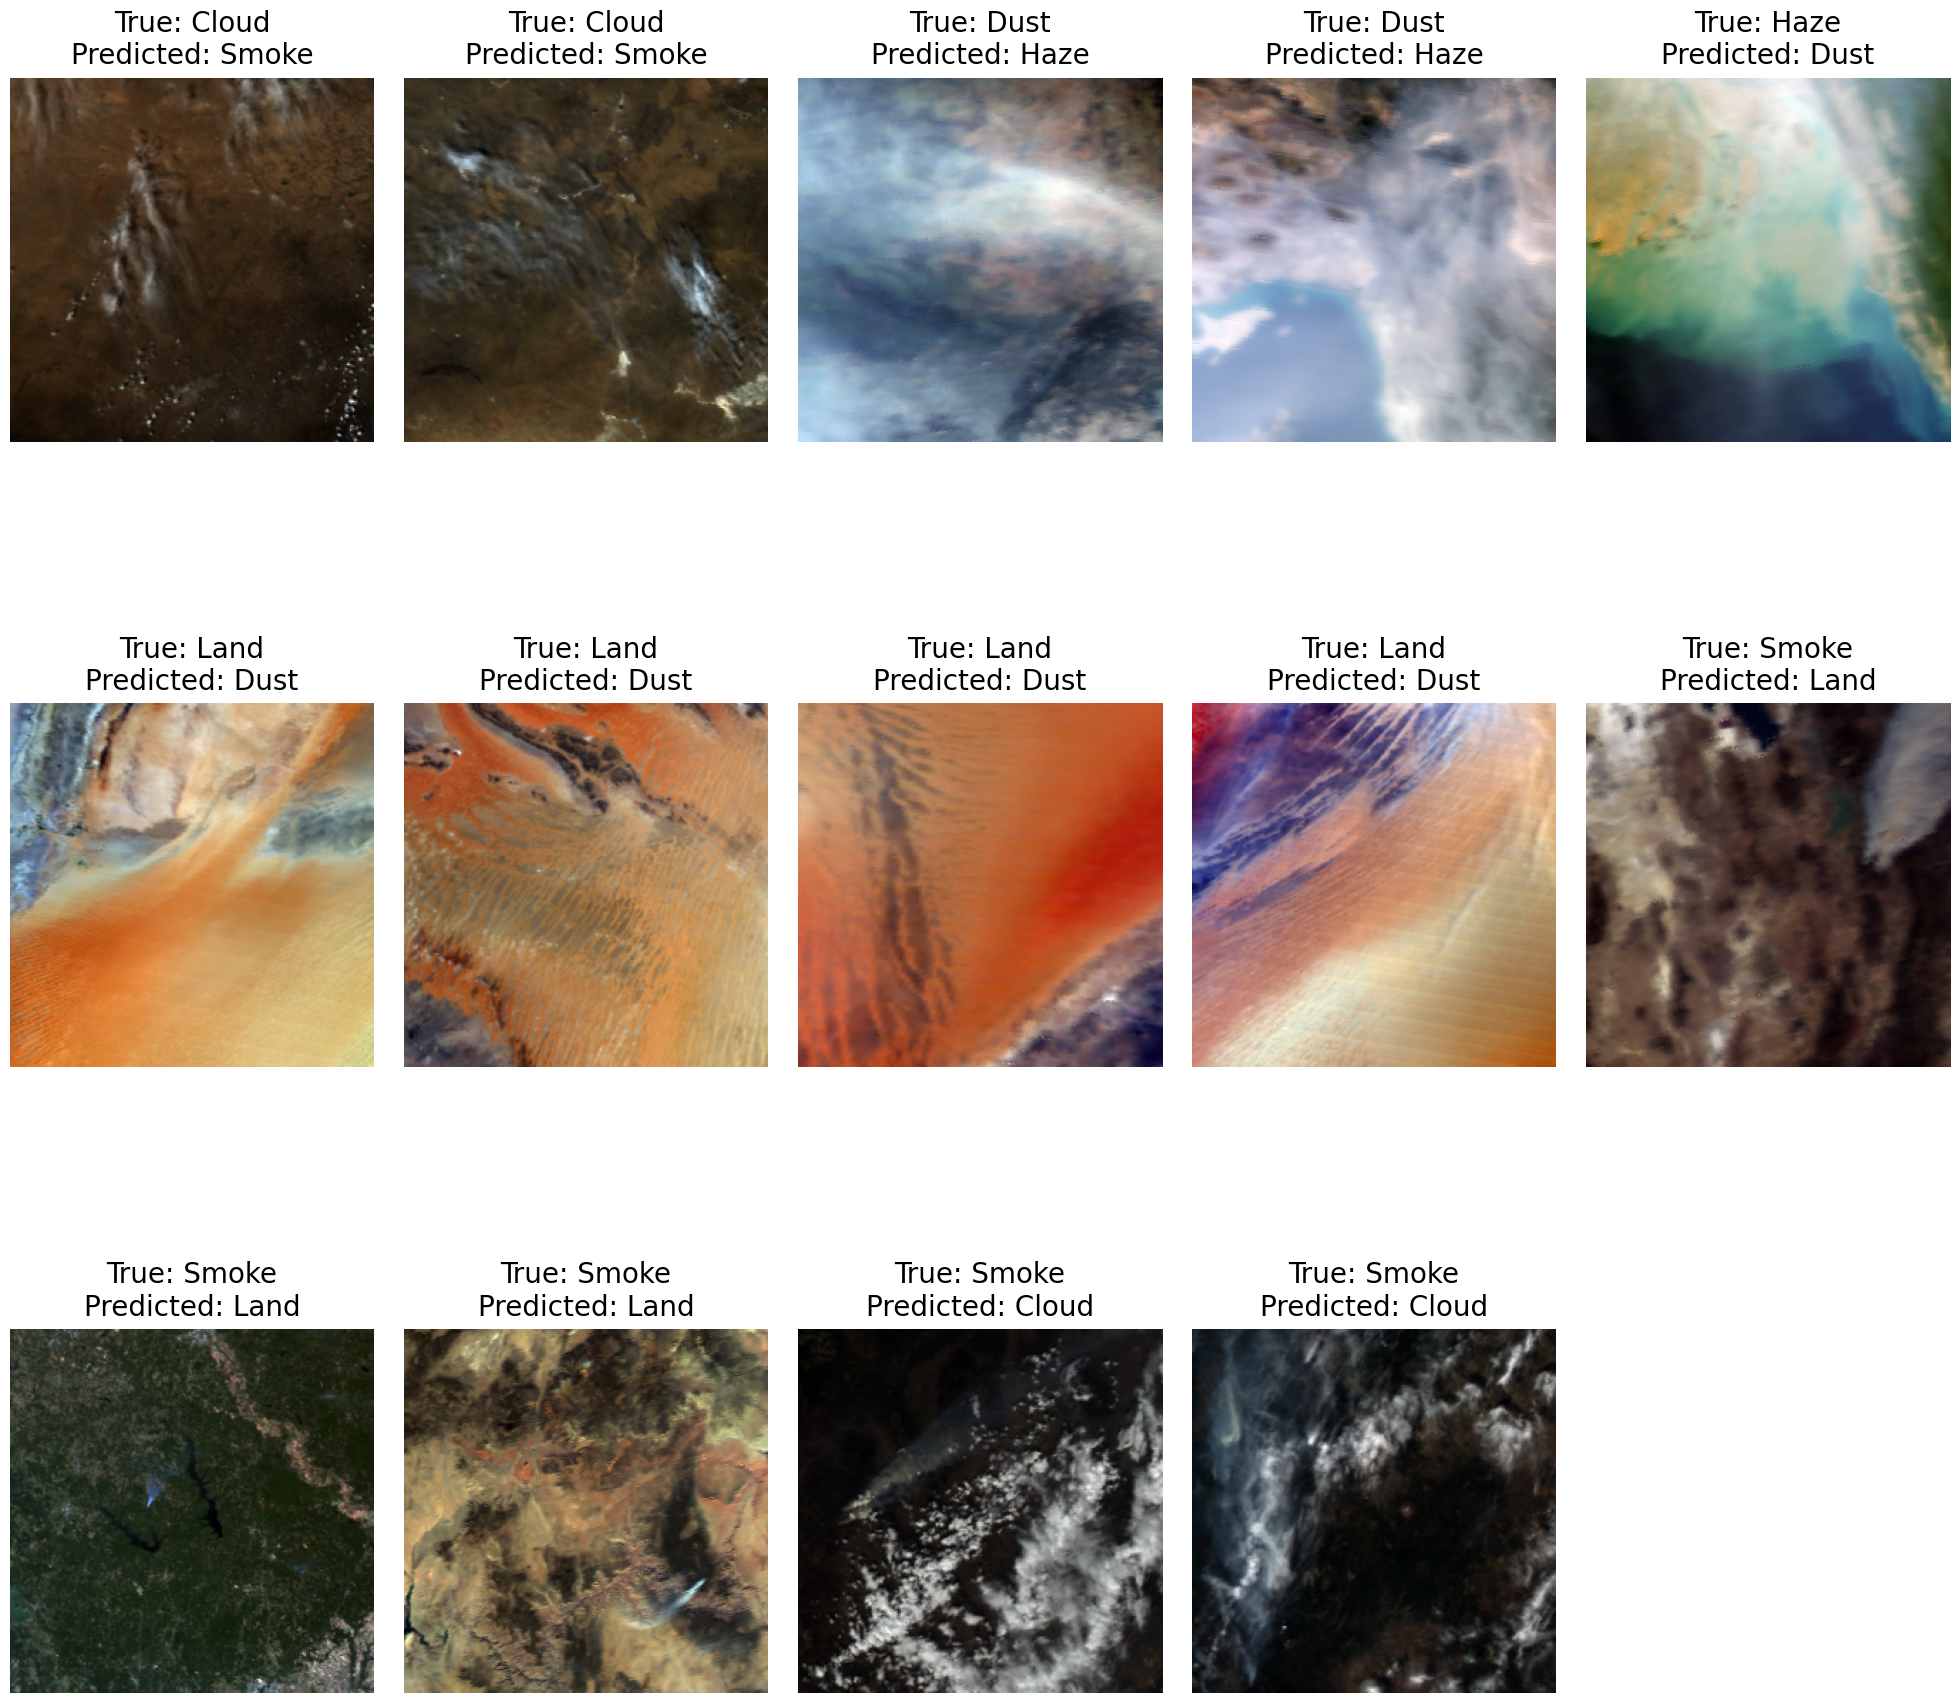

In [14]:
resnet50v1_wrong = np.where(pred_resnet50v1 != tf_y_true)[0]
resnet101v2_wrong = np.where(pred_resnet101v2 != tf_y_true)[0]
nasnetmobile_wrong = np.where(pred_nasnetmobile != tf_y_true)[0]
convnext_wrong = np.where(pred_convnextsmall != torch_y_true)[0]

intersections = list()
for i in resnet50v1_wrong: 
    if i in resnet101v2_wrong and i in nasnetmobile_wrong and i in convnext_wrong: 
        intersections.append(i)
intersections = np.array(intersections)

X_common_wrong = X_test_torch[intersections]
y_common_wrong = torch_y_true[intersections]

preds_wrong = {
    'ResNet50V1': pred_resnet50v1[intersections],
    'ResNet101V2': pred_resnet101v2[intersections],
    'NASNetMobile': pred_nasnetmobile[intersections],
    'ConvNeXtSmall': pred_convnextsmall[intersections]
}

same_mistakes = list()
for i in range(len(intersections)): 
    predictions = [preds_wrong[model][i] for model in preds_wrong.keys()]
    if len(set(predictions)) == 1: 
        if predictions[0] != y_common_wrong[i]: 
            same_mistakes.append(i)

same_mistakes = np.array(same_mistakes)
X_same_mistakes = X_common_wrong[same_mistakes]
y_same_mistakes_true = y_common_wrong[same_mistakes]
y_same_mistakes_pred = preds_wrong['ResNet50V1'][same_mistakes]

class_mapping = {idx: name for idx, name in enumerate(class_labels)}
n_images = len(same_mistakes)

n_images = len(same_mistakes)
print(f'Number of images that each architecture predicted the same wrong class on: {n_images}')

n_cols = 5  
n_rows = 3 

plt.figure(figsize=(20, 20))

for idx in range(n_images):
    plt.subplot(n_rows, n_cols, idx + 1)
    
    img = X_same_mistakes[idx].permute(1, 2, 0)

    plt.imshow(img)
    plt.axis('off')
    
    true_class = class_mapping[y_same_mistakes_true[idx]]
    pred_class = class_mapping[y_same_mistakes_pred[idx]]
    
    plt.title(f'True: {true_class}\nPredicted: {pred_class}', 
              fontsize=20, pad=10)

plt.tight_layout()

image_output_dir = '/Users/pimpijnenburg/Desktop/Thesis/USTC_SmokeRS_dataset/data/generated_images'
plot_output = os.path.join(image_output_dir, 'shared_prediction_mistakes.png')
plt.savefig(plot_output)

plt.show()
